<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stres_Prediction_BandDecomposition_CWT/blob/main/Pipeline3(EEG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Raw data mat.zip to Raw data mat.zip
Saving Documents and Code.zip to Documents and Code.zip
Saving DASPS+HAM labels.zip to DASPS+HAM labels.zip


In [2]:
import os
BASE_DIR="/content/DASPS"
os.makedirs(BASE_DIR,exist_ok=True)
print("Base folder created")


Base folder created


In [3]:
import shutil

for f in uploaded.keys():
    shutil.move(f, BASE_DIR+"/"+f)

os.listdir(BASE_DIR)


['DASPS+HAM labels.zip', 'Raw data mat.zip', 'Documents and Code.zip']

In [4]:
import zipfile

def unzip(z,out):
    with zipfile.ZipFile(z,'r') as f:
        f.extractall(out)

unzip("/content/DASPS/Raw data mat.zip",BASE_DIR)
unzip("/content/DASPS/DASPS+HAM labels.zip",BASE_DIR)
print("Extracted")


Extracted


In [5]:
!pip install h5py pywavelets scikit-learn matplotlib numpy


In [6]:
import h5py, numpy as np

f=h5py.File("/content/DASPS/Raw data mat/S01.mat",'r')
key=list(f.keys())[0]
eeg=np.array(f[key])

print("EEG shape:",eeg.shape)


EEG shape: (12, 1920, 14)


In [7]:
from sklearn.decomposition import FastICA

def apply_ica(eeg):
    ica=FastICA(n_components=eeg.shape[0], random_state=0)
    sources=ica.fit_transform(eeg.T)
    reconstructed=ica.inverse_transform(sources)
    return reconstructed.T


In [8]:
import pywt
import matplotlib.pyplot as plt

def save_cwt(signal, path):
    scales=np.arange(1,129)
    coeffs,freqs=pywt.cwt(signal,scales,'morl')

    plt.figure(figsize=(3,3))
    plt.imshow(np.abs(coeffs),
               cmap='jet',
               aspect='auto')
    plt.axis("off")
    plt.savefig(path,bbox_inches='tight',pad_inches=0)
    plt.close()


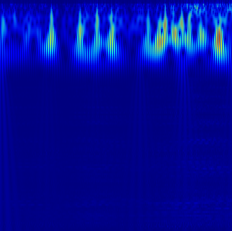

In [10]:
from sklearn.decomposition import FastICA
import pywt
import matplotlib.pyplot as plt
from IPython.display import Image

# Updated apply_ica function to handle 3D input and reshape for FastICA
def apply_ica(eeg_3d):
    # eeg_3d is expected to be (n_trials, n_samples_per_trial, n_channels)
    n_trials, n_samples_per_trial, n_channels = eeg_3d.shape

    # Reshape the 3D data into 2D for ICA: (total_samples, n_channels)
    # Total samples = n_trials * n_samples_per_trial
    eeg_2d = eeg_3d.reshape(-1, n_channels)

    # Initialize FastICA. n_components should typically be <= n_channels.
    # Setting n_components to n_channels to extract all possible components.
    # Added max_iter to prevent potential non-convergence issues.
    ica = FastICA(n_components=n_channels, random_state=0, max_iter=1000)

    # Apply ICA
    sources = ica.fit_transform(eeg_2d)

    # Reconstruct the signal
    reconstructed_2d = ica.inverse_transform(sources)

    # Reshape back to the original 3D shape: (n_trials, n_samples_per_trial, n_channels)
    reconstructed_3d = reconstructed_2d.reshape(n_trials, n_samples_per_trial, n_channels)

    return reconstructed_3d

clean = apply_ica(eeg)
# save_cwt expects a 1D signal. clean[0] is (1920, 14). We need to select one channel.
save_cwt(clean[0][:, 0], "/content/sample_pipeline3.png")
Image("/content/sample_pipeline3.png")

In [11]:
os.makedirs("/content/images/stress",exist_ok=True)
os.makedirs("/content/images/no_stress",exist_ok=True)


In [13]:
DATA="/content/DASPS/Raw data mat"

for file in os.listdir(DATA):
    sid=file.replace(".mat","")

    f=h5py.File(DATA+"/"+file,'r')
    key=list(f.keys())[0]
    eeg=np.array(f[key])

    eeg_clean=apply_ica(eeg)

    # Iterate over trials (first dimension of eeg_clean)
    for trial_idx in range(eeg_clean.shape[0]):
        # Iterate over channels (third dimension of eeg_clean)
        for channel_idx in range(eeg_clean.shape[2]):
            # Extract a 1D signal for a specific trial and channel
            signal_to_process = eeg_clean[trial_idx][:, channel_idx]
            save_cwt(signal_to_process,
                     f"/content/images/stress/{sid}_T{trial_idx}_CH{channel_idx}.png")

Subjects converted to Images

In [14]:
f=h5py.File("/content/DASPS/DASPS+HAM labels/DASPS+HAM labels.mat",'r')
labels=np.array(f[list(f.keys())[0]]).squeeze()


In [15]:
def get_binary_label(l):
    l=l.decode() if isinstance(l,bytes) else str(l)
    return 1 if l[0]=='1' else 0


In [16]:
BASE="/content/dataset"

folders=[
"train/stress","train/no_stress",
"val/stress","val/no_stress",
"test/stress","test/no_stress"
]

for f in folders:
    os.makedirs(os.path.join(BASE,f),exist_ok=True)


In [17]:
import glob,shutil

images=glob.glob("/content/images/stress/*.png")

for img in images:
    name=os.path.basename(img)
    sub=name.split("_")[0]
    idx=int(sub.replace("S",""))-1

    lab=get_binary_label(labels[idx])

    if lab==1:
        shutil.copy(img,f"{BASE}/train/stress/{name}")
    else:
        shutil.copy(img,f"{BASE}/train/no_stress/{name}")


In [18]:
from sklearn.model_selection import train_test_split

def split_class(cls):
    p=f"{BASE}/train/{cls}"
    files=os.listdir(p)

    train,temp=train_test_split(files,test_size=0.3,random_state=42)
    val,test=train_test_split(temp,test_size=0.5,random_state=42)

    for f in val:
        shutil.move(p+"/"+f,f"{BASE}/val/{cls}/"+f)
    for f in test:
        shutil.move(p+"/"+f,f"{BASE}/test/{cls}/"+f)

split_class("stress")
split_class("no_stress")


In [19]:
import shutil

shutil.make_archive(
    "/content/Pipeline3_dataset",
    "zip",
    "/content/dataset"
)

print("Pipeline-3 dataset zipped!")


Pipeline-3 dataset zipped!


In [20]:
from google.colab import files
files.download("/content/Pipeline3_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>